###Importing necessary libaries

In [29]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from gensim.models import Word2Vec
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

In [6]:
pip install gensim nltk

In [ ]:
!pip install sentence_transformers

### Using sentence transformer (SBERT) for embeddings tags

In [17]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [8]:
stop_words = set(stopwords.words('english'))
valid_words = set(words.words())

### Importing data about artist from last fm dataset

In [2]:
artist = pd.read_csv('/content/artist_info_final.csv')

In [3]:
artist.drop(columns=['Unnamed: 0', 'Unnamed: 9'], inplace=True)
artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11777 entries, 0 to 11776
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            11777 non-null  object
 1   MBID            11777 non-null  object
 2   similar_artist  11777 non-null  object
 3   listeners       11777 non-null  int64 
 4   play_counts     11777 non-null  int64 
 5   tags            11777 non-null  object
 6   summary         11777 non-null  object
 7   top_album       11777 non-null  object
 8   top_songs       11777 non-null  object
dtypes: int64(2), object(7)
memory usage: 828.2+ KB


In [6]:
def preprocess_text(text):
  if pd.isna(text):
    return []
  tokens = word_tokenize(text.lower())
  tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
  return tokens

### Preprocessing columns like summary and albums to be converted into vectors

In [9]:
artist['summary_tokens'] = artist['summary'].apply(preprocess_text)
artist['top_album_tokens'] = artist['summary'].apply(preprocess_text)
artist['top_songs_tokens'] = artist['summary'].apply(preprocess_text)

In [10]:
corpus = (
    artist['summary_tokens'].tolist() +
    artist['top_album_tokens'].tolist() +
    artist['top_songs_tokens'].tolist()
)

In [11]:
# using word2vec model for converting albums, songs and summary into vectors
word2Vec_model = Word2Vec(
    sentences = corpus,
    vector_size = 100,
    window = 5,
    workers = 1,
    sg = 1
)

In [12]:
def get_feature_vector(token, models):
  vectors = [models.wv[word] for word in token if word in models.wv]
  if len(vectors) == 0:
      return np.zeros(models.vector_size)
  return np.mean(vectors, axis = 0)

In [13]:
artist['summary_vector'] = artist['summary_tokens'].apply(lambda x: get_feature_vector(x, word2Vec_model))
artist['top_album_vector'] = artist['top_album_tokens'].apply(lambda x: get_feature_vector(x, word2Vec_model))
artist['top_song_vector'] = artist['top_songs_tokens'].apply(lambda x: get_feature_vector(x, word2Vec_model))

###Scaling listners count and play count logarithmically

In [14]:
artist['listeners'] = np.log1p(artist['listeners'])
artist['play_counts'] = np.log1p(artist['play_counts'])

In [15]:
def process_tags(tags):
    if isinstance(tags, list):
        return list(
            set(
                tag.lower()
                for tag in tags[:5]
                if len(tag.split()) <= 4
                and tag.lower() not in stop_words
            )
        )
    return tags

artist['tags'] = artist['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
artist['tags'] = artist['tags'].apply(process_tags)
unique_tags = set(tag for tag_list in artist['tags'] for tag in tag_list)
unique_tags = list(unique_tags)

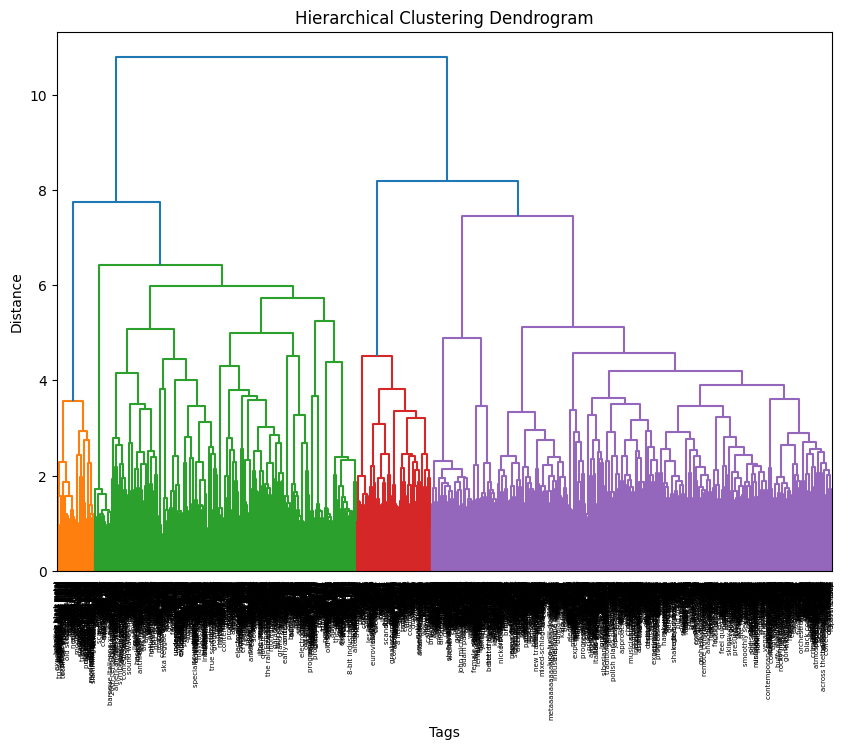

In [18]:
# using cosine similarity and doing heirarchical clustering to cluster all tags into 9 classes
tag_embeddings = model.encode(unique_tags)
cos_sim = cosine_similarity(tag_embeddings)
linkage_matrix = linkage(tag_embeddings, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=unique_tags, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Tags")
plt.ylabel("Distance")
plt.show()


In [19]:
clusterer = AgglomerativeClustering(n_clusters=9, metric='euclidean', linkage='ward')
clusters = clusterer.fit_predict(tag_embeddings)
tag_clusters = {tag: cluster for tag, cluster in zip(unique_tags, clusters)}


In [20]:
# defining cluster name
result = {}
for key, value in tag_clusters.items():
    if value not in result:
      result[value] = []
    result[value].append(key)

result_inverse = {}
result_inverse['romantic'] = result[0]
result_inverse['pop'] = result[1]
result_inverse['instrumental'] = result[2]
result_inverse['rock'] = result[3]
result_inverse['artist'] = result[4]
result_inverse['jazz']= result[5]
result_inverse['country music'] = result[6]
result_inverse['metal'] = result[7]
result_inverse['hardcore'] = result[8]
tag_to_cluster = {tag : cluster for cluster, tags in result_inverse.items() for tag in tags}

In [21]:
# assigning cluster according to prefernce order which is decided by no of tags in each cluster
def map_tag_to_cluster(tag_list):
  preference_order = ['hardcore', 'jazz', 'instrumental', 'country music', 'metal', 'rock', 'jazz', 'pop', 'romantic']
  mapped_clusters = [tag_to_cluster[tag] for tag in tag_list if tag in tag_to_cluster]
  mapped_clusters = list(set(mapped_clusters))
  for cluster in mapped_clusters:
    if cluster in preference_order:
      return str(cluster)


<Axes: ylabel='mapped_cluster'>

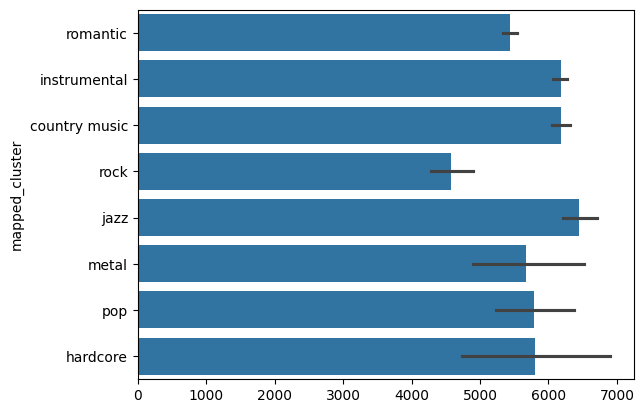

In [22]:
artist['mapped_cluster'] = artist['tags'].apply(map_tag_to_cluster)
sns.barplot(artist['mapped_cluster'])

In [23]:
# using Word2Vec to convert tags into vectors
similar_artist_list = artist['similar_artist'].tolist()
model = Word2Vec(sentences = similar_artist_list, vector_size = 100,
                 window = 5, min_count=1, sg = 1, workers=4)
artist['similar_artist_embedding'] = artist['similar_artist'].apply(lambda x: get_feature_vector(x, model))

In [24]:
# encoding the tags into labels
label_encoder = LabelEncoder()
artist['mapped_cluster_encoded'] = label_encoder.fit_transform(artist['mapped_cluster'])

In [25]:
test = artist.copy()
test.drop(columns=['MBID', 'similar_artist', 'tags', 'summary', 'top_album', 'summary_tokens', 'top_album_tokens', 'top_songs_tokens', 'mapped_cluster', 'top_songs'], inplace=True)
test.head(5)

,Name,listeners,play_counts,summary_vector,top_album_vector,top_song_vector,similar_artist_embedding,mapped_cluster_encoded
0,Nirvana,15.655611,19.852566,"[0.27162397, 0.31319883, 0.094084375, -0.24244...","[0.27162397, 0.31319883, 0.094084375, -0.24244...","[0.27162397, 0.31319883, 0.094084375, -0.24244...","[-0.16205104, 0.03735824, -0.026329935, 0.0433...",7
1,The Killers,15.598957,19.491057,"[0.18478118, 0.22997175, 0.02550292, -0.224587...","[0.18478118, 0.22997175, 0.02550292, -0.224587...","[0.18478118, 0.22997175, 0.02550292, -0.224587...","[-0.14511701, 0.03295271, -0.022498468, 0.0391...",7
2,Radiohead,15.734637,20.649002,"[0.12581062, 0.15351963, 0.17364843, -0.193422...","[0.12581062, 0.15351963, 0.17364843, -0.193422...","[0.12581062, 0.15351963, 0.17364843, -0.193422...","[-0.15204774, 0.041980684, -0.005074551, 0.036...",7
3,Gorillaz,15.541471,19.710063,"[0.051277418, 0.07203111, 0.17411812, -0.12370...","[0.051277418, 0.07203111, 0.17411812, -0.12370...","[0.051277418, 0.07203111, 0.17411812, -0.12370...","[-0.15653926, 0.041706096, -0.013944552, 0.051...",2
4,Coldplay,15.858085,20.200388,"[0.14708847, 0.23803574, 0.04089165, -0.314723...","[0.14708847, 0.23803574, 0.04089165, -0.314723...","[0.14708847, 0.23803574, 0.04089165, -0.314723...","[-0.15504941, 0.047037825, -0.028701864, 0.045...",7


In [26]:
# using horizontal stack to stack all vectors
features = np.hstack([
    np.vstack(test['summary_vector']),
    np.vstack(test['top_album_vector']),
    np.vstack(test['top_song_vector']),
    np.vstack(test['similar_artist_embedding']),
    test[['listeners', 'play_counts']].values
    ])

target = test['mapped_cluster_encoded'].values

### Training the model

In [27]:
# Using XGBoost Classifier
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=10,
    random_state=42
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)

### Accuracy of the model

In [30]:
# Accuracy and F1 score
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))


Accuracy: 0.5407470288624788
F1 Score: 0.5186992669375325
              precision    recall  f1-score   support

           0       0.49      0.37      0.42       517
           2       0.60      0.68      0.63       891
           3       0.70      0.28      0.40       127
           4       0.50      0.07      0.12        14
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00        89
           7       0.49      0.63      0.55       695
           8       0.00      0.00      0.00         2

    accuracy                           0.54      2356
   macro avg       0.35      0.25      0.27      2356
weighted avg       0.52      0.54      0.52      2356



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
tag = 1
ranked_artists_names = []
tag_probs = model.predict_proba(X_test)
ranked_artists = np.argsort(-tag_probs[:, tag])
top_name = [test['Name'].iloc[i] for i in ranked_artists[:10]]
ranked_artists_names.extend(top_name)
print("Top Recommended Artists for Tag", tag, ":", ranked_artists_names)


Top Recommended Artists for Tag 1 : ['Sleeping at Last', 'Paris Hilton', 'Rixton', 'Bob Dylan', 'St. Lucia', 'Tesla', 'Norah Jones', 'Smokey Robinson', 'Jane Monheit', 'Exposé']


In [32]:
tag = 7
ranked_artists_names = []
tag_probs = model.predict_proba(X_test)
ranked_artists = np.argsort(-tag_probs[:, tag])
top_name = [test['Name'].iloc[i] for i in ranked_artists[:10]]
ranked_artists_names.extend(top_name)
print("Top Recommended Artists for Tag", tag, ":", ranked_artists_names)


Top Recommended Artists for Tag 7 : ['Paul Stanley', 'The Mighty Bop', 'Andy Williams', 'Train', 'Atoms for Peace', 'Dark Tranquillity', 'Franz Schubert', 'Tonic', 'Jon Bon Jovi', 'Death Grips']


In [33]:
def precision_at_k(y_true, y_pred, k):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] in y_pred[i][:k]:
            correct += 1
    return correct / len(y_true)

precision = precision_at_k(y_test, [np.argsort(-probs) for probs in tag_probs], k=5)
print("Precision@5:", precision)


Precision@5: 0.9906621392190152
